In [1]:
import sys
sec_f = 24
from vinyl_srw.srwlib import *
from vinyl_srw.uti_plot import *
from scipy.ndimage.interpolation import zoom
import os
import numpy as np
import pandas as pd
from itertools import islice
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks,peak_widths
import os.path as path
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from config import get_from_config, save_to_config
import fur.path_assistant as path_assistant
srw_dir = path_assistant.get_srw_precalculated_spectrum_dir()

In [2]:
#fundamental constants
qe = get_from_config("e")
c = get_from_config("c_m/s")
me = get_from_config("me_kg")
hc = get_from_config("hc_um_eV")

In [3]:
undulator_Krms_vs_gap_mm = pd.read_csv(srw_dir.fi("Krms_vs_gap.csv"), header=None, skiprows=3).iloc[:,[0,1]]
undulator_Krms_vs_gap_mm = undulator_Krms_vs_gap_mm.rename(columns={0:"gap_mm",1:"K_rms"})
undulator_Krms_vs_gap_mm = undulator_Krms_vs_gap_mm[undulator_Krms_vs_gap_mm["K_rms"].notna()]

In [4]:
undulator_Krms_vs_gap_mm["K_peak"] = np.sqrt(2)*undulator_Krms_vs_gap_mm["K_rms"]
Kund = np.interp(get_from_config("Undulator_Gap_mm"),
                 undulator_Krms_vs_gap_mm["gap_mm"],
                 undulator_Krms_vs_gap_mm["K_peak"])
print("Kund = {:.4f}".format(Kund))
save_to_config("K_peak", Kund)

Kund = 1.0578


From FEL2012 paper:

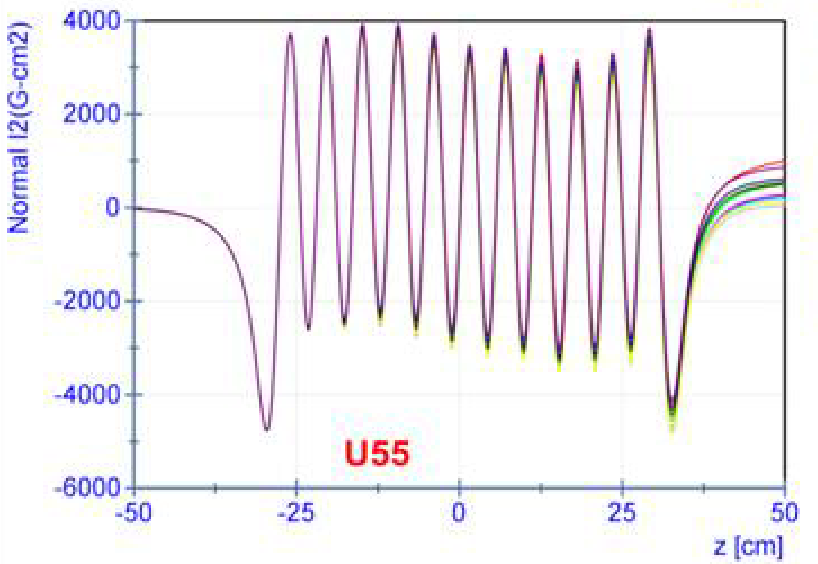

In [5]:
from IPython.display import Image
import fur.path_assistant as path_assistant
srw_dir = path_assistant.get_srw_precalculated_spectrum_dir()
Image(filename=srw_dir.fi("SLAC_undulator_I2.png"))

In [6]:
undulator_I2_gauss_cm2_df = pd.read_csv(srw_dir.fi("SLAC_undulator_I2.csv"), header=None)
K_und_paper = 2.0722
coef_to_x = qe/get_from_config("gamma")/me/c*0.01**2*1e-4*Kund/K_und_paper
undulator_x_m = coef_to_x*undulator_I2_gauss_cm2_df.iloc[:,1].values

In [7]:
#**********************Undulator constants:
numPer = 10 #6#Number of ID Periods (without counting for terminations; semi-integer => symmetric vs long. pos.; to allow harmonics to be symmetric or anti-symmetric?)
undPer = get_from_config("Undulator_period_m") #0.1106 #Period Length [m]
phBy = 0 #Initial Phase of the Vertical field component
Lund = numPer*undPer#1.7675
By = Kund*(2*np.pi*me*c)/(qe*undPer)#0.1514815555529875


part = SRWLParticle()
part.x = 0.0 #Initial Transverse Coordinates (initial Longitudinal Coordinate will be defined later on) [m]
part.y = 0.0
#part.z = -0.5*(numPer + 4)*undPer #Initial Longitudinal Coordinate (set 2 periods before pickup)
part.z = -0.5*(numPer + 4)*undPer #- 1.3981378
part.xp = 0 #Initial Transverse Velocities
part.yp = 0
part.gamma = get_from_config("gamma") #Relative Energy
part.relE0 = 1 #Electron Rest Mass
part.nq = -1 #Electron Charge


npTraj = 20000 #Number of Points for Trajectory calculation
dispBy = array('d', [0]*npTraj)
partTraj = SRWLPrtTrj(_arBy=dispBy) #you can consider it as a part of allocation, values of B field are still zero here
partTraj.partInitCond = part
partTraj.allocate(npTraj, False)
partTraj.ctStart = 0.0 #Start Time for the calculation
#partTraj.ctEnd = fmult*undPer*(numPer+4) #End Time ~1.2166
#partTraj.ctEnd = undPer*(numPer+4)/2+1.3981378+3*zdcent_f
partTraj.ctEnd = undPer*(numPer+4) #+1.#+3*zdcent_f

lmb_0 = undPer/(2*part.gamma**2)*(1 + Kund**2/2.0)
print("lambda1_um = {}".format(lmb_0))

lambda1_um = 1.119847549714982e-06


In [8]:
#***********Magnetic Field
sBy = 1 #Symmetry of the Vertical field component vs Longitudinal position
xcID = 0 #Transverse Coordinates of Undulator Center [m]
ycID = 0
zcID = 0 #Longitudinal Coordinate of Undulator Center [m]
und = SRWLMagFldU([SRWLMagFldH(1, 'v', By, phBy, sBy, 1)], undPer, numPer) #Planar Undulator
magFldCnt = SRWLMagFldC([und], array('d', [xcID]), array('d', [ycID]), array('d', [zcID])) #Container of all Field Elements

In [9]:
partTraj = srwl.CalcPartTraj(partTraj, magFldCnt, [1])# why was the last argument 0 and not [1] or something like this

arX = np.asarray(partTraj.arX)
arZ = np.asarray(partTraj.arZ)
arXp = np.asarray(partTraj.arXp)
arZp = np.asarray(partTraj.arZp)

ct_list = np.linspace(partTraj.ctStart, partTraj.ctEnd, partTraj.np)-np.mean((partTraj.ctStart, partTraj.ctEnd))

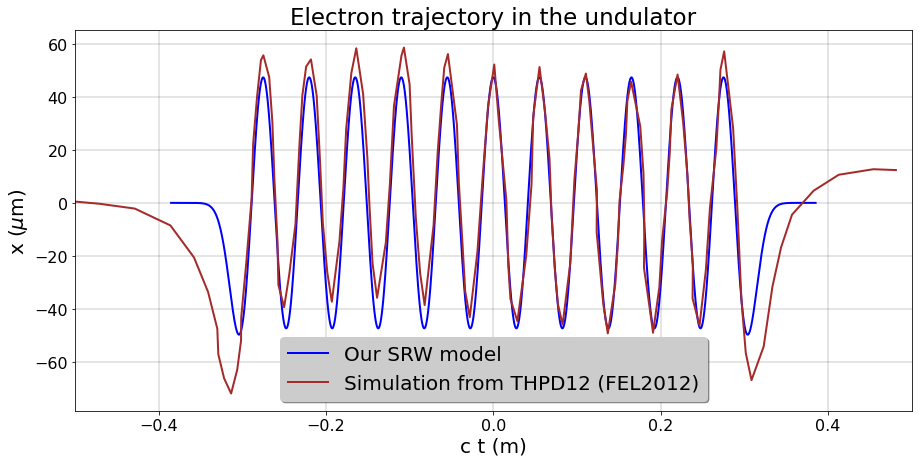

In [10]:
fig,ax = plt.subplots(figsize=[15,7])
plt.plot(ct_list,-arX*1e6,linewidth=2,color = 'b',label='Our SRW model')
plt.plot(-0.015+undulator_I2_gauss_cm2_df.iloc[:,0],
undulator_x_m*1e6,linewidth=2,color='brown',label='Simulation from THPD12 (FEL2012)')
legend = ax.legend(loc='bottom right', shadow=True, fontsize=20, frameon=True)
ax.set_xlabel('c t (m)', fontsize=20)
ax.set_ylabel('x ($\mu$m)', fontsize=20)
plt.title('Electron trajectory in the undulator', fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.tick_params(axis='both', which='minor', labelsize=16)
ax.grid(color='k', linestyle='-', linewidth=2, alpha=0.1)
frame = legend.get_frame()
frame.set_facecolor('0.8')
ax.set_xlim(-0.5,0.5)
for label in legend.get_lines():
       label.set_linewidth(2)  # the legend line width
plt.show()

In [11]:
#***********Electron Beam
f_ring = 7.5e6
Iavg_se = qe*f_ring

elecBeam = SRWLPartBeam()
elecBeam.Iavg = Iavg_se #Average Current [A]
elecBeam.partStatMom1 = part

Iavg_se

1.2016324755e-12

In [12]:
#***********Precision Parameters for SR calculation
meth = 1 #SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
relPrec = 0.01 #relative precision
zStartInteg = 0 #longitudinal position to start integration (effective if < zEndInteg)
zEndInteg = 0 #longitudinal position to finish integration (effective if > zStartInteg)
useTermin = 1 #Use "terminating terms" (i.e. asymptotic expansions at zStartInteg and zEndInteg) or not (1 or 0 respectively)
sampFactNxNyForProp = 0 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [meth, relPrec, zStartInteg, zEndInteg, npTraj, useTermin, sampFactNxNyForProp]
rad_mesh = get_from_config("radiation_mesh")
xs = rad_mesh[0][0]
xf = rad_mesh[0][1]
ys = rad_mesh[1][0]
yf = rad_mesh[1][1]
zobs = get_from_config("z_obs_m")
xbins = rad_mesh[0][2]
ybins = rad_mesh[1][2]
ls = rad_mesh[2][0]
lf = rad_mesh[2][1]
lbins = rad_mesh[2][2]
l_list = np.linspace(ls, lf, lbins)
Ex_3D = np.zeros(shape=(lbins, ybins, xbins), dtype=complex)
Ey_3D = np.zeros(shape=(lbins, ybins, xbins), dtype=complex)
coef = zobs*np.sqrt(1e9*qe/Iavg_se)

In [13]:
def to_2D(values_1D):
    np_E = np.asarray(values_1D)
    np_E_Real = np_E[::2].reshape((ybins,xbins))
    np_E_Imag = np_E[1::2].reshape((ybins,xbins))
    return np_E_Real+1j*np_E_Imag

In [14]:
from IPython.display import clear_output
for k, l in enumerate(l_list):
    print('Working on {} out of {}'.format(k+1, len(l_list)),' ... ')
    wfr2 = SRWLWfr() #For intensity distribution at fixed photon energy
    wfr2.allocate(1, xbins, ybins) #Numbers of points vs Photon Energy, Horizontal and Vertical Positions
    wfr2.mesh.zStart = zobs #Longitudinal Position [m] at which SR has to be calculated
    wfr2.mesh.xStart = xs #Initial Horizontal Position [m]
    wfr2.mesh.xFin = xf #Final Horizontal Position [m]
    wfr2.mesh.yStart = ys #Initial Vertical Position [m]
    wfr2.mesh.yFin = yf #Final Vertical Position [m]
    wfr2.partBeam = elecBeam
    pe = hc/l
    wfr2.mesh.eStart = pe #Initial Photon Energy [eV]
    wfr2.mesh.eFin =  pe #Final Photon Energy [eV]
    srwl.CalcElecFieldSR(wfr2, partTraj, magFldCnt, arPrecPar)
    Ex_3D[k,:,:] = coef/np.sqrt(l)*to_2D(wfr2.arEx)
    Ey_3D[k,:,:] = coef/np.sqrt(l)*to_2D(wfr2.arEy)
    clear_output(wait=True)
print("Done.")

Done.


In [20]:
dx = (xf-xs)/(xbins-1)
dy = (yf-ys)/(ybins-1)
dl = (l_list[-1]-l_list[0])/(lbins-1)

In [16]:
dx/zobs*dy/zobs*dl*np.sum(np.absolute(Ex_3D)**2)

0.023144132603199086

In [17]:
dx/zobs*dy/zobs*dl*np.sum(np.absolute(Ey_3D)**2)

0.0013837879913094966

In [18]:
dx/zobs*dy/zobs*dl*np.sum(np.absolute(Ex_3D)**2+np.absolute(Ey_3D)**2)

0.02452792059450846

In [19]:
import fur.path_assistant as path_assistant
np.save(path_assistant.srw_Ex_3D_file_path, Ex_3D)
np.save(path_assistant.srw_Ey_3D_file_path, Ey_3D)